In [1]:
import pandas as pd
import json
import matplotlib.pyplot as plt
from multiprocessing import Process, Pool
from threading import Thread
import time
%matplotlib inline

# Nacteni dat

In [2]:
with open("/home/kuba/ownCloud/ModGen-fac-mat/sample-data-v2/movielens_1m/items.json",'r') as f:
    items = json.loads(f.read())

with open("/home/kuba/ownCloud/ModGen-fac-mat/sample-data-v2/movielens_1m/properties.json",'r') as f:
    properties = json.loads(f.read())
    
with open("/home/kuba/ownCloud/ModGen-fac-mat/sample-data-v2/movielens_1m/user.folds.json",'r') as f:
    user_folds = json.loads(f.read())
    
with open("/home/kuba/ownCloud/ModGen-fac-mat/sample-data-v2/movielens_1m/users.int2str.json",'r') as f:
    users_int2str = json.loads(f.read())
    
with open("/home/kuba/ownCloud/ModGen-fac-mat/sample-data-v2/movielens_1m/users.str2int.json",'r') as f:
    users_str2int = json.loads(f.read())
      
ratings = pd.read_csv('/home/kuba/ownCloud/ModGen-fac-mat/sample-data-v2/movielens_1m/ratings.csv')

with open("/home/kuba/ownCloud/ModGen-fac-mat/sample-data-v2/movielens_1m/items.int2str.json",'r') as f:
    items_int2str = json.loads(f.read())
    
with open("/home/kuba/ownCloud/ModGen-fac-mat/sample-data-v2/movielens_1m/items.str2int.json",'r') as f:
    items_str2int = json.loads(f.read())

# Faktorizace

In [3]:
import multiprocessing
import ctypes
import numpy as np

In [4]:
import numpy as np
# %load_ext line_profiler

In [8]:
class MatrixFactorization:
    def __init__(self, ratings, no_factors):
        self.Ratings = ratings.pivot_table(columns=['itemId'],index=['userId'],values='rating')
        self.Ratings_matrix = self.Ratings.values
        self.Weights = np.isfinite(self.Ratings_matrix).astype(np.float64, copy=False)
        self.Idx = np.isfinite(self.Ratings_matrix)
        self.ratings_dict = dict(ratings.apply(lambda r:( (str(int(r.userId)),str(int(r.itemId))),{
                                                                    'rating':r.rating,
                                                                     }), axis=1).values)
        self.no_factors = no_factors
        
        shared_array_base = multiprocessing.Array(ctypes.c_double, np.random.rand(self.Ratings.shape[0]* no_factors))
        shared_array = np.ctypeslib.as_array(shared_array_base.get_obj())
        shared_array = shared_array.reshape(self.Ratings.shape[0], no_factors)
        self.Users = shared_array.reshape(self.Ratings.shape[0], no_factors)
        
        shared_array_base = multiprocessing.Array(ctypes.c_double, np.random.rand(self.Ratings.shape[1]* no_factors))
        shared_array = np.ctypeslib.as_array(shared_array_base.get_obj())
        shared_array = shared_array.reshape(no_factors, self.Ratings.shape[1])
        self.Items = shared_array.reshape(no_factors, self.Ratings.shape[1])
        
    '''
    RMSE
    '''  
    def get_error(self, R, U, V, W):
        return np.sum(np.nan_to_num((W * (R - np.dot(U, V))))**2)
    
    '''
    OPTIMAZE
    '''
     
    def optimize_rmse_solver(self, lambda_, no_iterations):
        weighted_errors = []
        R = np.nan_to_num(self.Ratings_matrix)
        V = self.Items
        U = self.Users
        W = self.Idx.astype(np.float64, copy=False)
        
        for ii in range(no_iterations):
            for u, Wu in enumerate(W):
                U[u] = np.linalg.solve(np.dot(V, np.dot(np.diag(Wu), V.T)) + lambda_ * np.eye(self.no_factors),
                                       np.dot(V, np.dot(np.diag(Wu), R[u].T))).T
            for i, Wi in enumerate(W.T):
                V[:,i] = np.linalg.solve(np.dot(U.T, np.dot(np.diag(Wi), U)) + lambda_ * np.eye(self.no_factors),
                                         np.dot(U.T, np.dot(np.diag(Wi), R[:, i])))
            weighted_errors.append(self.get_error(R, U, V, W))
            if(not ii % 20):
                print('{}th iteration is completed'.format(ii))
                print(weighted_errors[-1])
                self.R_hat = np.dot(U,V)
                
        return weighted_errors
    
    def compute_factor(self,queue):
        while True:
            task = queue.get()
            if(task[0]=='item'):
                self.compute_item_factor(task[1])
            if(task[0]=='user'):
                self.compute_user_factor(task[1])
            queue.task_done()
            
    def compute_item_factor(self, batch):
        R, V, U, Idx, lambda_, alfa = self.Ratings_matrix, self.Items, self.Users, self.Idx, self.lambda_, self.alfa
        for i in batch:
            V[:,i] += -alfa * (np.dot((np.dot(V[:,i],U[Idx[:,i],:].T) - R[Idx[:,i],i]), U[Idx[:,i],:]) + lambda_ * V[:,i])
        return
    
    def compute_user_factor(self, batch):
        R, V, U, Idx, lambda_, alfa = self.Ratings_matrix, self.Items, self.Users, self.Idx, self.lambda_, self.alfa
        for u in batch:
            U[u] += -alfa * (np.dot((np.dot(U[u], V[:,Idx[u,:]]) - R[u, Idx[u,:]]), V[:,Idx[u,:]].T) + lambda_* U[u] )
        return
    
    def optimize_rmse_gradient_descent(self, lambda_, no_iterations, alfa = 0.01, no_process = 1):
        weighted_errors = []
        R = np.nan_to_num(self.Ratings_matrix)
        V = self.Items
        U = self.Users
        Idx = self.Idx
        self.lambda_ = lambda_
        self.alfa = alfa
        
        
        step_item = int(np.ceil(len(V.T)/float(no_process)))
        step_user = int(np.ceil(len(U)/float(no_process)))
        
        item_range = [range(i,min(len(V.T), i+step_item)) for i in range(0, len(V.T), step_item)]
        user_range = [range(i,min(len(U), i+step_user)) for i in range(0, len(U), step_user)]
        print("Item range", item_range)
        print("User range", user_range)
        
        queue = multiprocessing.JoinableQueue(500)

        process = []
        for p in range(no_process):
            p = Process(target = self.compute_factor, args = (queue,))
            process.append(p)
            p.daemon = True
            p.start()
        

        for ii in range(no_iterations):
            for batch in item_range:
                queue.put(("item",batch),True)
            for batch in user_range:
                queue.put(("user",batch),True)
                
            queue.join()                

            weighted_errors.append(self.get_error(self.Ratings_matrix, self.Users, self.Items, self.Idx))
            if(not ii % 200):
                print('{}th iteration is completed'.format(ii))
                print(weighted_errors[-1])

                self.R_hat = np.dot(U,V)
                
        return weighted_errors
    
    def plot_rmse(self, weighted_errors):
        plt.plot(np.log(weighted_errors), label="weighted error: "+str(weighted_errors[-1]))
        plt.ylabel("RMSE log scale")
        plt.xlabel("no iterations")

        plt.legend()
        plt.show()
        
    def optimaze(self, lambda_, no_iterations, loss_function="RMSE", method="solver", alfa=0.001, no_process = 1):
        if(loss_function == "RMSE" and method == "solver"):
            weighted_errors = self.optimize_rmse_solver(lambda_, no_iterations)
            
        if(loss_function == "RMSE" and method == "gradient-descent"):
            weighted_errors = self.optimize_rmse_gradient_descent(lambda_, no_iterations, alfa, no_process)

        self.plot_rmse(weighted_errors)
       

In [9]:
# %lprun -f MFact.rmse_optimalization MFact.rmse_optimalization(0.001, 0.0001, 5)

Item range [range(0, 927), range(927, 1854), range(1854, 2781), range(2781, 3706)]
User range [range(0, 1510), range(1510, 3020), range(3020, 4530), range(4530, 6040)]
0th iteration is completed
16546334.0592


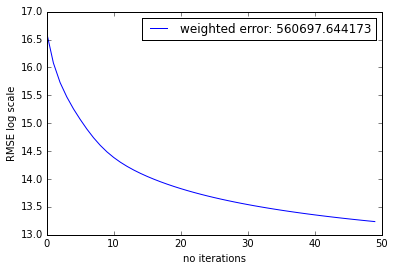

CPU times: user 21.4 s, sys: 2.93 s, total: 24.3 s
Wall time: 41.2 s


datetime.timedelta(0, 69, 287262)

In [10]:
import datetime
a = datetime.datetime.now()
MFact = MatrixFactorization(ratings[:4000000].copy(), 30)
%time MFact.optimaze(0.001, 50, method="gradient-descent", alfa = 0.0001, no_process = 4)

datetime.datetime.now() - a